In [2]:
#Includes necesarios
from sklearn.naive_bayes import GaussianNB

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import train_test_split

from auxiliar import get_train_set,get_holdout_set,create_prediction
import preprocessing as pr

from auxiliar import plot_cm,plot_tree
from sklearn.metrics import classification_report,plot_roc_curve

# **Gaussian Naive Bayes**

Obtenemos el dataset con el cual entrenaremos nuestro modelo. Para este modelo se opto unicamente tratar los missings como categoricos:

In [3]:
X,y = get_train_set()
X = pr.init_dataset(X)

Para aplicar este tipo de modelo debemos quedarnos solo con las columnas continuas. En este caso no nos hace falta aplicar OHE, puesto que todas las columnas que nos quedan son numericas. Tampoco nos sirve los preprocesamientos de reduccion o discretizacion puesto que esto eliminaria o generaria nuevas columnas categoricas.

In [4]:
X_continuos = pr.select_types(X,types=['int64','int32'])
X_continuos.head()

,anios_estudiados,edad,ganancia_perdida_declarada_bolsa_argentina,horas_trabajo_registradas
0,17,39,2174,40
1,17,50,0,13
2,13,38,0,40
3,11,53,0,40
4,17,28,0,40


Partimos nuestro set en *train* y *validation*:

In [5]:
X_train, X_validation, y_train, y_validation = train_test_split(X_continuos,y, test_size=0.2, stratify=y)

Busco los mejores hiperparametros para el arbol de decision con GridSearchCV. La metrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.

In [6]:
parameters = {
    'var_smoothing': np.arange(0, 0.0000001,0.00000001)
}

clf = GaussianNB()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")
print("------------------")
print(f"Score in Validation: {gscv.score(X_validation, y_validation)}")

Best score: 0.8343026924315593
Best params {'var_smoothing': 1e-08}
------------------
Score in Validation: 0.8433800504529416


Armo el modelo con los hiperparametros calculados:

In [7]:
model_gaussianNB = gscv.best_estimator_
model_gaussianNB

GaussianNB(var_smoothing=1e-08)

Predigo con el validation set:

In [8]:
gaussianNB_predict = model_gaussianNB.predict(X_validation)

**Metricas**

In [9]:
print(classification_report(y_validation, gaussianNB_predict))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      4945
           1       0.77      0.22      0.34      1568

    accuracy                           0.80      6513
   macro avg       0.79      0.60      0.61      6513
weighted avg       0.79      0.80      0.75      6513



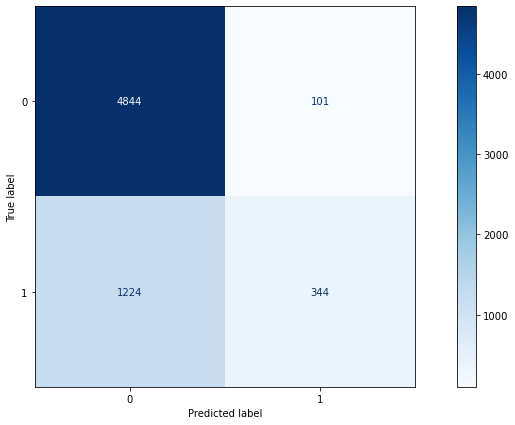

In [10]:
plot_cm(model_gaussianNB, X_validation, y_validation)

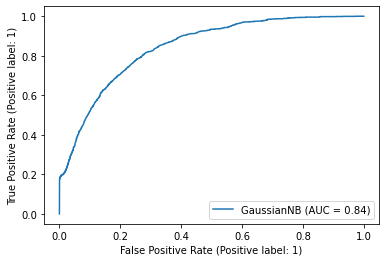

In [11]:
plot_roc_curve(model_gaussianNB, X_validation, y_validation, response_method="predict_proba")
plt.show()

### Preprocesamiento: Normalizacion

Ahora veremos que al realizar una normalizacion a nuestras columnas continuas tenemos una perdida de performance en la metrica *roc_auc*:

In [24]:
X_p1 = pr.normalize(X_continuos)
X_p1

array([[7.81686779e-03, 1.79328143e-02, 9.99639446e-01, 1.83926301e-02],
       [3.12571831e-01, 9.19328914e-01, 0.00000000e+00, 2.39025518e-01],
       [2.29344320e-01, 6.70391090e-01, 0.00000000e+00, 7.05674832e-01],
       ...,
       [1.81450312e-01, 8.09547547e-01, 0.00000000e+00, 5.58308653e-01],
       [4.00616808e-01, 6.77966906e-01, 0.00000000e+00, 6.16333551e-01],
       [8.65273642e-04, 3.46109457e-03, 9.99990092e-01, 2.66238044e-03]])

Partimos nuestro set en *train* y *validation*:

In [25]:
X_train, X_validation, y_train, y_validation = train_test_split(X_p1,y, test_size=0.2, stratify=y)

Busco los mejores hiperparametros para el arbol de decision con GridSearchCV. La metrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.

In [26]:
parameters = {
    'var_smoothing': np.arange(0, 0.0000001,0.00000001)
}

clf = GaussianNB()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")
print("------------------")
print(f"Score in Validation: {gscv.score(X_validation, y_validation)}")

Best score: 0.6191348096003086
Best params {'var_smoothing': 8e-08}
------------------
Score in Validation: 0.6167374925197582


In [27]:
model_gaussianNB_p1 = gscv.best_estimator_
model_gaussianNB_p1

GaussianNB(var_smoothing=8e-08)

Predigo con el validation set:

In [29]:
gaussianNB_predict = model_gaussianNB_p1.predict(X_validation)

**Metricas**

In [30]:
print(classification_report(y_validation, gaussianNB_predict))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      4945
           1       0.57      0.32      0.41      1568

    accuracy                           0.78      6513
   macro avg       0.69      0.62      0.64      6513
weighted avg       0.75      0.78      0.76      6513



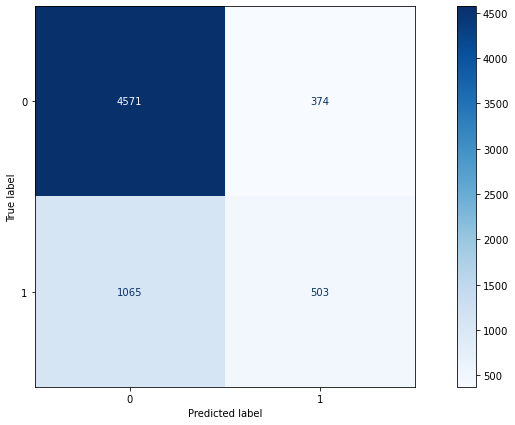

In [31]:
plot_cm(model_gaussianNB_p1, X_validation, y_validation)

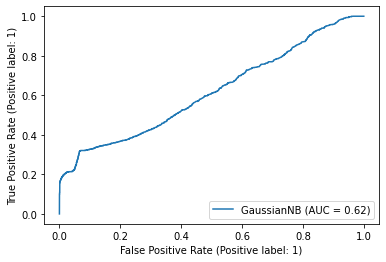

In [32]:
plot_roc_curve(model_gaussianNB_p1, X_validation, y_validation, response_method="predict_proba")
plt.show()

# Conclusión

Vimos que utilizando GaussianNB quedandonos solo con las columnas numericas obtenemos una mal performance de la metrica *roc_auc* en comparación con los demas modelos. Aplicando una normalizacion de estas columnas numericas nos genera una perdida de performance.

# Predicción

In [ ]:
ids, X_holdout = get_holdout_set()
X_holdout = pr.init_dataset(X_holdout)

In [ ]:
X_holdout_continuos = pr.select_types(X_holdout,types=['int64','int32'])

In [ ]:
gaussianNB_predict = model_gaussianNB.predict(X_holdout_continuos)

In [ ]:
create_prediction(ids,gaussianNB_predict,file_name='gaussianNB')